# 準備

## Googleドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [2]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code_colab_lesson_1_2')

# simple convolution network

## image to column

In [10]:
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# 画像データを２次元配列に変換
'''
input_data: 入力値
filter_h: フィルターの高さ
filter_w: フィルターの横幅
stride: ストライド
pad: パディング
'''
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    
    col = col.reshape(N * out_h * out_w, -1)
    return col

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] im2colの処理を確認しよう
・関数内でtransposeの処理をしている行をコメントアウトして下のコードを実行してみよう<br>
・input_dataの各次元のサイズやフィルターサイズ・ストライド・パディングを変えてみよう

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 3
filter_w = 3
stride = 1
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[58. 89. 15. 83.]
   [69. 34. 12. 99.]
   [75. 61.  2. 29.]
   [77. 15. 66. 66.]]]


 [[[49. 31. 82.  5.]
   [68. 55. 91. 71.]
   [94.  2. 33. 42.]
   [18. 81. 59. 14.]]]]
============= col ==============
 [[58. 89. 69. 34. 89. 15. 34. 12. 15.]
 [83. 12. 99. 69. 34. 75. 61. 34. 12.]
 [61.  2. 12. 99.  2. 29. 75. 61. 77.]
 [15. 61.  2. 15. 66.  2. 29. 66. 66.]
 [49. 31. 68. 55. 31. 82. 55. 91. 82.]
 [ 5. 91. 71. 68. 55. 94.  2. 55. 91.]
 [ 2. 33. 91. 71. 33. 42. 94.  2. 18.]
 [81.  2. 33. 81. 59. 33. 42. 59. 14.]]


In [11]:
# im2colの処理確認
# transposeをコメントアウト
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 3
filter_w = 3
stride = 1
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[98. 80. 65. 59.]
   [36. 39. 75. 83.]
   [17. 22.  0. 65.]
   [27.  8. 73. 88.]]]


 [[[51. 28. 61. 94.]
   [45. 63. 14. 75.]
   [54. 25. 91. 53.]
   [79. 38. 95. 91.]]]]
============= col ==============
 [[98. 80. 36. 39. 80. 65. 39. 75. 65.]
 [59. 75. 83. 36. 39. 17. 22. 39. 75.]
 [22.  0. 75. 83.  0. 65. 17. 22. 27.]
 [ 8. 22.  0.  8. 73.  0. 65. 73. 88.]
 [51. 28. 45. 63. 28. 61. 63. 14. 61.]
 [94. 14. 75. 45. 63. 54. 25. 63. 14.]
 [25. 91. 14. 75. 91. 53. 54. 25. 79.]
 [38. 25. 91. 38. 95. 91. 53. 95. 91.]]


In [18]:
# im2colの処理確認
# 入力11x11、フィルター5x5、パディング2、ストライド2
input_data = np.random.rand(2, 1, 11, 11)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 5
filter_w = 5
stride = 2
pad = 2
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[85.  8.  6. 99. 82. 29. 58. 49.  9. 62. 69.]
   [ 3. 33. 63.  5. 79. 29. 38. 36. 57. 67. 81.]
   [61. 42. 34. 89. 83. 57. 63. 66. 84. 87. 37.]
   [36. 86. 53. 20. 58. 97. 60. 63. 91. 39. 51.]
   [12. 15. 60. 22. 12. 29. 96. 48. 60. 12. 70.]
   [94. 98. 15. 29. 55.  8. 21. 17. 47. 81. 41.]
   [94. 19. 62. 38. 75. 88. 81. 11.  5. 15. 67.]
   [96. 61.  3. 52. 29. 83. 85. 39. 90.  6. 94.]
   [97. 49. 57. 80. 24. 81. 37. 62. 25.  6. 15.]
   [ 9. 96.  4. 84. 87. 45. 59. 64. 11. 81. 64.]
   [20. 93. 51. 83. 83. 62. 25. 67. 95. 33. 40.]]]


 [[[54. 93. 47.  6. 30. 65. 21.  3. 41. 11. 83.]
   [ 4. 75. 66. 48. 80. 41. 56. 47.  5. 40. 31.]
   [55. 94. 61. 47. 71. 82. 56. 25. 81.  5.  8.]
   [96.  0. 72. 47. 12. 23. 84. 49. 83. 23.  8.]
   [27. 53. 87. 87. 41. 37. 22. 62. 80. 28. 61.]
   [62. 81. 30. 60. 38. 97.  6. 25. 46. 98. 99.]
   [58.  7. 91. 73. 69. 31. 37. 36. 57. 64.  6.]
   [52. 18. 73. 82. 69. 59.  4. 49. 69. 30. 41.]
   [75. 14. 56.  3. 76. 86.  1

In [19]:
col.shape

(72, 25)

## column to image

In [5]:
# ２次元配列を画像データに変換
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_shape
    # 切り捨て除算    
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2) # (N, filter_h, filter_w, out_h, out_w, C)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## col2imの処理を確認しよう
・im2colの確認で出力したcolをimageに変換して確認しよう

In [21]:
col2im(col, (2,1,11,11), 5, 5, 2, 2)

array([[[[107., 107., 143.,  89., 122., 254., 205., 165., 175., 111.,
           11.],
         [167.,  63., 207.,  11., 209., 322., 345., 164., 280., 221.,
           78.],
         [282., 184., 347., 168., 399., 306., 363., 281., 435., 200.,
          369.],
         [130., 206., 228., 152., 207., 200., 243., 212., 253., 124.,
          151.],
         [350., 303., 422., 299., 332., 239., 365., 313., 260., 165.,
          200.],
         [123., 142., 256., 161., 140., 148., 223., 142., 330., 141.,
          195.],
         [247., 211., 332., 341., 453., 202., 330., 217., 438., 275.,
          294.],
         [151.,  11., 197., 322., 246., 138., 222., 177., 313., 131.,
          115.],
         [270., 158., 386., 367., 414., 200., 414., 187., 440., 278.,
          225.],
         [134., 282., 255., 198., 310., 212., 320., 124., 190.,  24.,
           94.],
         [124.,  66., 219.,  90., 147., 165., 173.,  94., 126., 149.,
          180.]]],


       [[[143.,  97., 220.,  93., 181.,

## convolution class

In [6]:
class Convolution:
    # W: フィルター, b: バイアス
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # フィルター・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        # FN: filter_number, C: channel, FH: filter_height, FW: filter_width
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        # 出力値のheight, width
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        
        # xを行列に変換
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルターをxに合わせた行列に変換
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        # 計算のために変えた形式を戻す
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        # dcolを画像データに変換
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


## pooling class

In [7]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # xを行列に変換
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # プーリングのサイズに合わせてリサイズ
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 行ごとに最大値を求める
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # 整形
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


## sinple convolution network class

In [8]:
class SimpleConvNet:
    # conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']        
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W3'], self.params['b3'])

        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W3'], grad['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.3312
                : 10. 正答率(テスト) = 0.312
Generation: 20. 正答率(トレーニング) = 0.664
                : 20. 正答率(テスト) = 0.66
Generation: 30. 正答率(トレーニング) = 0.7246
                : 30. 正答率(テスト) = 0.702
Generation: 40. 正答率(トレーニング) = 0.7934
                : 40. 正答率(テスト) = 0.756
Generation: 50. 正答率(トレーニング) = 0.8048
                : 50. 正答率(テスト) = 0.777
Generation: 60. 正答率(トレーニング) = 0.8632
                : 60. 正答率(テスト) = 0.827
Generation: 70. 正答率(トレーニング) = 0.8592
                : 70. 正答率(テスト) = 0.816
Generation: 80. 正答率(トレーニング) = 0.8862
                : 80. 正答率(テスト) = 0.847
Generation: 90. 正答率(トレーニング) = 0.893
                : 90. 正答率(テスト) = 0.855
Generation: 100. 正答率(トレーニング) = 0.8846
                : 100. 正答率(テスト) = 0.858
Generation: 110. 正答率(トレーニング) = 0.8962
                : 110. 正答率(テスト) = 0.869
Generation: 120. 正答率(トレーニング) = 0.901
                : 120. 正答率(テスト) = 0.882
Generation: 130. 正答率(トレーニング) = 0.9076
                : 130. 正答率(テスト) = 0.86

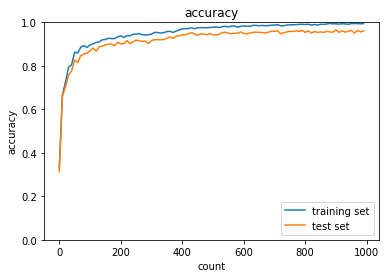

In [9]:
from common import optimizer

# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("データ読み込み完了")

# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]


network = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10



for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()